<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/CNN_Implementation_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt

In [15]:
mnist_tr = dset.MNIST("./dataset/mnist", train=True, download=True, transform=T.ToTensor())
mnist_te = dset.MNIST("./dataset/mnist", train=False, download=True, transform=T.ToTensor())

NUM_TRAIN = 60000
NUM_VALID = 60000
NUM_TEST = 10000

batch_size = 128

loader_tr = DataLoader(mnist_tr, batch_size=batch_size, shuffle=True)
loader_va = DataLoader(mnist_tr, batch_size=batch_size, shuffle=True)
loader_te = DataLoader(mnist_te, batch_size=batch_size, shuffle=True)

In [17]:
def build_classifier_mnist():
  return nn.Sequential(
    nn.Conv2d(in_channels=1,
              out_channels=16,
              kernel_size=3,
              stride=2,
              padding=1,
              padding_mode='zeros',
              bias=True),
    nn.LeakyReLU(0.01),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=1),
    nn.Conv2d(in_channels=16,
              out_channels=32,
              kernel_size=3,
              stride=2,
              padding=0,
              bias=True),
    nn.LeakyReLU(0.01),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=0),
    nn.Conv2d(in_channels=32,
              out_channels=64,
              kernel_size=3,
              stride=2,
              padding=0,
              bias=True),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(64*2*2, 100),
    nn.LeakyReLU(0.01),
    nn.Linear(100, 10),
    nn.Softmax(dim=1)
)

In [18]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    """https://github.com/pytorch/examples/blob/main/imagenet/main.py"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(1.0 / batch_size))
        return res

In [19]:
### Training
dtype = torch.cuda.FloatTensor
model = build_classifier_mnist().cuda(0)
cost_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
cost_list = []
for epoch in range(10):
  for x, y in loader_tr:
    #if len(x) != batch_size:
      #continue
    y_hat = model(x.type(dtype)).cpu()
    cost = cost_func(y_hat, y)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    cost_list.append(cost.detach().numpy())

  y_pred = []
  target = []
  for x, y in loader_va:
    y_pred.append(model(x.type(dtype)).cpu())
    target.append(y)

  y_pred = torch.cat(y_pred)
  target = torch.cat(target)
  accu_top1 = accuracy(y_pred, target, topk=(1,))[0].numpy()[0]
  accu_top5 = accuracy(y_pred, target, topk=(5,))[0].numpy()[0]
  loss_val = cost_func(y_pred, target)

  print(f"epoch:{epoch:d}, loss@val:{loss_val:.3f}, acurracy@top1:{accu_top1:.3f}, acurracy@top5:{accu_top5:.3f}")

epoch:0, loss@val:0.000, acurracy@top1:0.941, acurracy@top5:0.998
epoch:1, loss@val:0.000, acurracy@top1:0.964, acurracy@top5:0.999
epoch:2, loss@val:0.000, acurracy@top1:0.975, acurracy@top5:0.999
epoch:3, loss@val:0.000, acurracy@top1:0.979, acurracy@top5:1.000
epoch:4, loss@val:0.000, acurracy@top1:0.979, acurracy@top5:1.000
epoch:5, loss@val:0.000, acurracy@top1:0.984, acurracy@top5:1.000
epoch:6, loss@val:0.000, acurracy@top1:0.979, acurracy@top5:1.000
epoch:7, loss@val:0.000, acurracy@top1:0.985, acurracy@top5:1.000
epoch:8, loss@val:0.000, acurracy@top1:0.985, acurracy@top5:1.000
epoch:9, loss@val:0.000, acurracy@top1:0.986, acurracy@top5:1.000


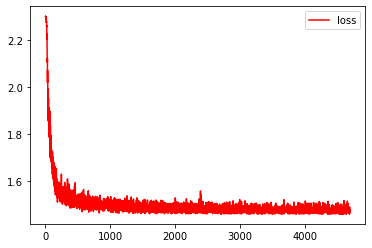

In [21]:
plt.figure('CNN_MNIST_Loss')
plt.plot(cost_list,label='loss', c='r')
plt.legend()

In [33]:
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_tr = dset.CIFAR10("./dataset/cifar10", train=True, download=True, transform=transform_train)
cifar10_te = dset.CIFAR10("./dataset/cifar10", train=False, download=True, transform=transform_test)

NUM_TRAIN = 50000
NUM_TEST = 10000

batch_size = 128

loader_tr = DataLoader(cifar10_tr, batch_size=batch_size, shuffle=True)
loader_te = DataLoader(cifar10_te, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


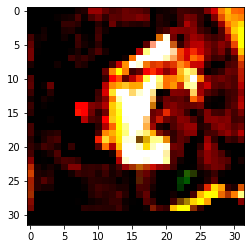

In [34]:
plt.imshow(cifar10_tr[0][0].numpy().T)

In [37]:
def build_classifier_cifar(output_dim = 10):
  return nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=64,
              kernel_size=3,
              stride=2,
              padding=2,
              padding_mode='zeros',
              bias=True),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,),
    nn.Conv2d(in_channels=64,
              out_channels=128,
              kernel_size=3,
              stride=2,
              padding=1,
              bias=True),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=0),
    nn.Conv2d(in_channels=128,
              out_channels=256,
              kernel_size=3,
              stride=2,
              padding=1,
              bias=True),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=0),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(256*3*3, 256*3*3),
    nn.ReLU(),
    nn.Linear(256*3*3, output_dim),
    nn.Softmax(dim=1)
)

In [38]:
dtype = torch.cuda.FloatTensor
model = build_classifier_cifar(10).cuda(0)
cost_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
cost_list = []
for epoch in range(50):
  for x, y in loader_tr:
    #if len(x) != batch_size:
      #continue
    y_hat = model(x.type(dtype)).cpu()
    cost = cost_func(y_hat, y)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    cost_list.append(cost.detach().numpy())

  if (epoch+1)%5 == 0:
    y_pred = []
    target = []
    for x, y in loader_te:
      y_pred.append(model(x.type(dtype)).cpu())
      target.append(y)

    y_pred = torch.cat(y_pred)
    target = torch.cat(target)
    accu_top1 = accuracy(y_pred, target, topk=(1,))[0].numpy()[0]
    accu_top5 = accuracy(y_pred, target, topk=(5,))[0].numpy()[0]
    loss_val = cost_func(y_pred, target)

    print(f"epoch:{epoch+1:d}, loss@val:{loss_val:.3f}, acurracy@top1:{accu_top1:.3f}, acurracy@top5:{accu_top5:.3f}")

epoch:5, loss@val:1.891, acurracy@top1:0.575, acurracy@top5:0.938
epoch:10, loss@val:1.823, acurracy@top1:0.642, acurracy@top5:0.958
epoch:15, loss@val:1.777, acurracy@top1:0.687, acurracy@top5:0.967
epoch:20, loss@val:1.759, acurracy@top1:0.706, acurracy@top5:0.969
epoch:25, loss@val:1.747, acurracy@top1:0.717, acurracy@top5:0.973
epoch:30, loss@val:1.720, acurracy@top1:0.745, acurracy@top5:0.978
epoch:35, loss@val:1.705, acurracy@top1:0.759, acurracy@top5:0.978
epoch:40, loss@val:1.702, acurracy@top1:0.761, acurracy@top5:0.981
epoch:45, loss@val:1.697, acurracy@top1:0.764, acurracy@top5:0.982
epoch:50, loss@val:1.680, acurracy@top1:0.783, acurracy@top5:0.983


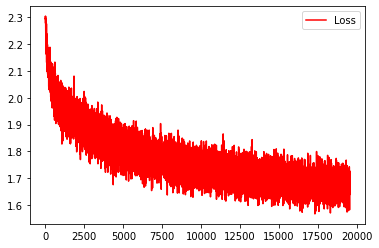

In [40]:
plt.figure('CNN_CIFAR10_Loss')
plt.plot(cost_list,label='Loss', c='r')
plt.legend()